In [1]:
from gymnasium import Env
from gymnasium.spaces.box import Box
import numpy as np
import random
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback, StopTrainingOnRewardThreshold, EvalCallback
from stable_baselines3.common.noise import NormalActionNoise
import wandb
from wandb.integration.sb3 import WandbCallback
import os
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pickle
import warnings
import math
warnings.filterwarnings("ignore")

In [2]:
class BobinaEnvTest(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering just two degrees of freedom.
  """
  def __init__(self, alive = 20, masa_pod = 250, airgap = 16.3, duration = 10, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5):
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100, -100]), high = np.array([100, 100]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([-10, -10, -np.inf, -np.inf, -45, -45]), high = np.array([10, 10, np.inf, np.inf, 45, 45]), dtype=np.float32)
    # Initial parameters
    airgap = random.uniform(15.3, 17.3)
    self.state = np.array([airgap - 16.3, airgap - 16.3, 0, 0, 0, 0])
    self.airgapinicial = airgap
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = self.airgapinicial, dist_cm = dist_cm, inercia= inercia, min_distance = min_distance, max_distance = max_distance)
    self.steps = []
    self.airgap1 = airgap
    self.airgap2 = airgap
    self.distancia1 = 0
    self.distancia2 = 0
    self.velocidad = 0
    self.current1 = 0
    self.current2 = 0
    self.alive = alive
    self.vel = 0
    self.velangular = 0


  def step(self, action):
    # Apply action
    self.state, self.crash, angulo, error = self.sistema.step(action[0],action[1])
    self.distancia1, self.distancia2, self.vel, self.velangular, self.current1, self.current2 = self.state

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Calculate reward
    reward = -abs(self.distancia1) -abs(self.distancia2) - 10000*self.crash

    """if self.airgap >= 23: reward = -500
    elif self.airgap <= 10: reward = -500
    else: reward = -abs(self.current)"""

    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented the crash
    """if self.crash:
      reward = - 100000
      terminated = True
    else:
      terminated = False"""
    terminated = False
    self.steps.append(self.state)
    return self.state, reward, terminated, truncated, info


  def render(self, yes = "yes", normalize = True, seed = 0):
    # create data
    x = list(range(0,len(self.steps)))
    y1 = [16.3+step[0] for step in self.steps]
    y2 = [16.3+step[1] for step in self.steps]
    objective = [16.3]*len(self.steps)

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    #ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    #ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black
    if normalize: ax.set_ylim(bottom=8, top=23)
    plt.xlabel("Time (s)") #, color='white')
    plt.ylabel("Airgap (mm)") #, color='white')
    plt.title("Airgap evolution") #, color='white')

    plt.plot(x, y1, label = "Airgap 1")
    plt.plot(x, y2, label = "Airgap 2")
    plt.plot(x, objective, label = "Objective")
    plt.legend()
    #if self.steps[0][0] < 0: plt.savefig("images/top-2gdl8x8nocrash.png")
    #else: plt.savefig("images/bottom-2gdl8x8nocrash.png")
    plt.savefig(f"images/2gdl8x8nocrashsituation{seed}.png")
    plt.show()

  def reset(self, seed = 0):
    # Reset experiment choosing randomly the start (ceiling or floor)
    airgap = random.uniform(9.5, 22)
    #self.state = np.array([airgap - 16.3, airgap - 16.3, 0, 0, 0, 0])
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = airgap, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5)
    angulo = random.uniform(-0.008, 0.008)
    self.vel = random.uniform(-0.2, 0.2)
    self.velangular = random.uniform(-0.3, 0.3)
    self.current1 = 0
    self.current2 = 0
    airgap1, airgap2 = self.sistema.pos2airgap(pos = airgap, theta = angulo)
    self.distancia1, self.distancia2 = airgap1-16.3, airgap2-16.3
    self.state= self.distancia1, self.distancia2, self.vel, self.velangular, self.current1, self.current2
    self.sistema.integral_aceleracion = self.vel
    self.sistema.integral_alpha = self.velangular
    self.sistema.integral_omega = angulo
    self.state, self.crash = self.sistema.step(0,0)
    self.distancia11, self.distancia12, self.distancia21, self.distancia22, self.current1, self.current2 = self.state
    
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [3]:
class TestAngleEnv(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering just two degrees of freedom.
  """
  def __init__(self, alive = 20, masa_pod = 250, airgap = 16.3, duration = 10, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5):
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100, -100]), high = np.array([100, 100]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([-10, -10, -10, -10, -45, -45]), high = np.array([10, 10, 10, 10, 45, 45]), dtype=np.float32)
    # Initial parameters
    airgap = random.uniform(10, 21.5)
    variacion = random.uniform(-0.06, 0.06)
    self.state = np.array([airgap - 16.3, airgap - 16.3, airgap + variacion - 16.3, airgap + variacion - 16.3, 0, 0])
    self.airgapinicial = airgap + variacion
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = self.airgapinicial, dist_cm = dist_cm, inercia= inercia, min_distance = min_distance, max_distance = max_distance)
    self.sistema.integral_aceleracion = variacion
    self.steps = []
    self.airgap1 = airgap
    self.airgap2 = airgap 
    self.distancia1 = 0
    self.distancia2 = 0
    self.velocidad = 0
    self.current1 = 0
    self.current2 = 0
    self.alive = alive
    self.vel = variacion
    self.velangular = 0
    self.prev_error = (airgap - 16.3/7.3)**2


  def step(self, action):
    # Apply action
    self.state, self.crash = self.sistema.step(action[0],action[1])
    self.distancia11, self.distancia12, self.distancia21, self.distancia22, self.current1, self.current2 = self.state

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Calculate reward
    error = ((self.distancia12/7.3)**2 + (self.distancia22/7.3)**2)/2
    reward_raw = 1 - error
    if self.crash: 
      reward_bonus = -0.4
    else:
      if self.prev_error > error: reward_bonus = 0.2
      else: reward_bonus = -0.2

    reward = reward_raw + reward_bonus
    self.prev_error = error



    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented the crash
    """if self.crash:
      reward = - 100000
      terminated = True
    else:
      terminated = False"""
    terminated = False
    self.steps.append(self.state)
    return self.state, reward, terminated, truncated, info


  def render(self, yes = "yes", normalize = True, seed = 0):
    # create data
    x = list(range(0,len(self.steps)))
    y1 = [16.3+step[0] for step in self.steps]
    y2 = [16.3+step[2] for step in self.steps]
    objective = [16.3]*len(self.steps)

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    #ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    #ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black
    if normalize: ax.set_ylim(bottom=8, top=23)
    plt.xlabel("Time (s)") #, color='white')
    plt.ylabel("Airgap (mm)") #, color='white')
    plt.title("Airgap evolution") #, color='white')

    plt.plot(x, y1, label = "Airgap 1")
    plt.plot(x, y2, label = "Airgap 2")
    plt.plot(x, objective, label = "Objective")
    plt.legend()
    #if self.steps[0][0] < 0: plt.savefig("images/top-2gdl8x8nocrash.png")
    #else: plt.savefig("images/bottom-2gdl8x8nocrash.png")
    plt.savefig(f"images/2gdl8x8nocrashsituation{seed}.png")
    plt.show()

  def reset(self, seed = 0):
    # Reset experiment choosing randomly the start (ceiling or floor)
    airgap = random.uniform(10, 21.5)
    variacion = random.uniform(-0.06, 0.06)
    self.state = np.array([airgap - 16.3, airgap - 16.3, airgap + variacion - 16.3, airgap + variacion - 16.3, 0, 0])
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = airgap, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5)
    self.sistema.integral_alpha = variacion
    
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [4]:
class TestSpeedEnv(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering just two degrees of freedom.
  """
  def __init__(self, alive = 20, masa_pod = 250, airgap = 16.3, duration = 10, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5):
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100, -100]), high = np.array([100, 100]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([-10, -10, -10, -10, -45, -45]), high = np.array([10, 10, 10, 10, 45, 45]), dtype=np.float32)
    # Initial parameters
    airgap = random.uniform(10, 21.5)
    variacion = random.uniform(-0.06, 0.06)
    self.state = np.array([airgap - 16.3, airgap + variacion - 16.3, airgap - 16.3, airgap + variacion - 16.3, 0, 0])
    self.airgapinicial = airgap + variacion
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = self.airgapinicial, dist_cm = dist_cm, inercia= inercia, min_distance = min_distance, max_distance = max_distance)
    self.sistema.integral_aceleracion = variacion
    self.steps = []
    self.airgap1 = airgap
    self.airgap2 = airgap 
    self.distancia1 = 0
    self.distancia2 = 0
    self.velocidad = 0
    self.current1 = 0
    self.current2 = 0
    self.alive = alive
    self.vel = variacion
    self.velangular = 0
    self.prev_error = (airgap - 16.3/7.3)**2


  def step(self, action):
    # Apply action
    self.state, self.crash = self.sistema.step(action[0],action[1])
    self.distancia11, self.distancia12, self.distancia21, self.distancia22, self.current1, self.current2 = self.state

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Calculate reward
    error = ((self.distancia12/7.3)**2 + (self.distancia22/7.3)**2)/2
    reward_raw = 1 - error
    if self.crash: 
      reward_bonus = -0.4
    else:
      if self.prev_error > error: reward_bonus = 0.2
      else: reward_bonus = -0.2

    reward = reward_raw + reward_bonus
    self.prev_error = error



    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented the crash
    """if self.crash:
      reward = - 100000
      terminated = True
    else:
      terminated = False"""
    terminated = False
    self.steps.append(self.state)
    return self.state, reward, terminated, truncated, info


  def render(self, yes = "yes", normalize = True, seed = 0):
    # create data
    x = list(range(0,len(self.steps)))
    y1 = [16.3+step[0] for step in self.steps]
    y2 = [16.3+step[2] for step in self.steps]
    objective = [16.3]*len(self.steps)

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    #ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    #ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black
    if normalize: ax.set_ylim(bottom=8, top=23)
    plt.xlabel("Time (s)") #, color='white')
    plt.ylabel("Airgap (mm)") #, color='white')
    plt.title("Airgap evolution") #, color='white')

    plt.plot(x, y1, label = "Airgap 1")
    plt.plot(x, y2, label = "Airgap 2")
    plt.plot(x, objective, label = "Objective")
    plt.legend()
    #if self.steps[0][0] < 0: plt.savefig("images/top-2gdl8x8nocrash.png")
    #else: plt.savefig("images/bottom-2gdl8x8nocrash.png")
    plt.savefig(f"images/2gdl8x8nocrashsituation{seed}.png")
    plt.show()

  def reset(self, seed = 0):
    # Reset experiment choosing randomly the start (ceiling or floor)
    airgap = random.uniform(10, 21.5)
    variacion = random.uniform(-0.06, 0.06)
    self.state = np.array([airgap - 16.3, airgap + variacion - 16.3, airgap - 16.3, airgap + variacion - 16.3, 0, 0])
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = airgap, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5)
    self.sistema.integral_aceleracion = variacion
    self.vel = variacion
    
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [2]:
class BobinaEnv(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering just two degrees of freedom.
  """
  def __init__(self, alive = 20, masa_pod = 250, airgap = 16.3, duration = 10, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5):
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100, -100]), high = np.array([100, 100]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([-10, -10, -10, -10, -45, -45]), high = np.array([10, 10, 10, 10, 45, 45]), dtype=np.float32)
    # Initial parameters
    airgap = random.choice([16.3])
    self.state = np.array([airgap - 16.3, airgap - 16.3, airgap - 16.3, airgap - 16.3, 0, 0])
    self.airgapinicial = airgap
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = self.airgapinicial, dist_cm = dist_cm, inercia= inercia, min_distance = min_distance, max_distance = max_distance)
    self.steps = []
    self.airgap1 = airgap
    self.airgap2 = airgap
    self.distancia1 = 0
    self.distancia2 = 0
    self.velocidad = 0
    self.current1 = 0
    self.current2 = 0
    self.alive = alive
    self.vel = 0
    self.velangular = 0
    self.prev_error = (airgap - 16.3/7.3)**2


  def step(self, action):
    # Apply action
    self.state, self.crash = self.sistema.step(action[0],action[1])
    self.distancia11, self.distancia12, self.distancia21, self.distancia22, self.current1, self.current2 = self.state

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Calculate reward
    error = ((self.distancia12/7.3)**2 + (self.distancia22/7.3)**2)/2
    reward_raw = 1 - error
    if self.crash: 
      reward_bonus = -0.4
    else:
      if self.prev_error > error: reward_bonus = 0.2
      else: reward_bonus = -0.2

    reward = reward_raw + reward_bonus
    self.prev_error = error



    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented the crash
    """if self.crash:
      reward = - 100000
      terminated = True
    else:
      terminated = False"""
    terminated = False
    self.steps.append(self.state)
    return self.state, reward, terminated, truncated, info


  def render(self, yes = "yes", normalize = True, seed = 0):
    # create data
    x = list(range(0,len(self.steps)))
    y1 = [16.3+step[0] for step in self.steps]
    y2 = [16.3+step[2] for step in self.steps]
    objective = [16.3]*len(self.steps)

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    #ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    #ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black
    if normalize: ax.set_ylim(bottom=8, top=23)
    plt.xlabel("Time (s)") #, color='white')
    plt.ylabel("Airgap (mm)") #, color='white')
    plt.title("Airgap evolution") #, color='white')

    plt.plot(x, y1, label = "Airgap 1")
    plt.plot(x, y2, label = "Airgap 2")
    plt.plot(x, objective, label = "Objective")
    plt.legend()
    #if self.steps[0][0] < 0: plt.savefig("images/top-2gdl8x8nocrash.png")
    #else: plt.savefig("images/bottom-2gdl8x8nocrash.png")
    plt.savefig(f"images/2gdl8x8nocrashsituation{seed}.png")
    plt.show()

  def reset(self, seed = 0):
    # Reset experiment choosing randomly the start (ceiling or floor)
    airgap = random.choice([16.3])
    self.state = np.array([airgap - 16.3, airgap - 16.3, airgap - 16.3, airgap - 16.3, 0, 0])
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = airgap, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5)
    
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [7]:
class Bobina():
  """ 
  Coil model for the Hybrid Electromagnetic Suspension
  """
  def __init__(self, masa_pod = 250, airgap = 22.5, min_distance = 9, max_distance = 22.5):
    self.masa_pod = masa_pod
    self.airgap = airgap
    self.aceleracion = []
    self.velocidad = []
    mat = scipy.io.loadmat('../coil/hems.mat')
    self.hems = mat["hems"][0][0]
    self.airgaps = self.hems[0][0]
    self.currents = self.hems[1][0]
    self.force_vertical = pickle.load(open("../coil/mlp_vertical.pkl", 'rb'))
    self.flux = self.hems[3]
    self.force_horizontal = self.hems[4]
    self.inductance = pickle.load(open("../coil/rf_inductance.pkl", 'rb'))
    self.resistance = self.hems[6][0][0]
    self.min_distance = min_distance
    self.max_distance = max_distance
    self.airgapinicial = airgap
    self.crash = False
    self.current = 0
    self.steps_RL = []

  def integral(self, lista, h = 1):
    return sum(h*(lista[i]+lista[i+1])/2 for i in range(len(lista)-1))

  def RL(self, airgap, target_voltage, temperature):
    # Resistance-Inductance circuit

    # Get resistance of the coil
    R = self.R(current = self.current, temperature = temperature)   
    V = target_voltage
    I = self.current
    L = self.L(airgap = airgap, current = self.current)
    dIdt = ((V/R) - I)/(L/R)                                      
    self.steps_RL.append(dIdt)                                   
    current = self.integral(self.steps_RL, h = 0.001)                          
    return current                                                  

  def R(self, current, temperature):
    return self.resistance                                         

  def L(self, airgap, current):
    # Return predicted inductance
    return float(self.inductance.predict(np.array([[airgap, current]]))[0])

  def vertical_force(self, airgap, target_voltage, temperature):
    # Get current from RL circuit
    I = self.RL(airgap = airgap, target_voltage = target_voltage, temperature = temperature) 
    
    # Clip result
    if I > 45:
      I = 45
    elif I < -45:
      I = -45
    self.current = I
    # Get vertical force from 
    FI = self.FI_vertical(airgap = airgap, current = I)                    
    return FI, I


  def FI_vertical(self, airgap, current):
    # Return predicted vertical force
    return float(self.force_vertical.predict(np.array([[airgap, current]])))    


  def next_airgap(self, masa_pod, vertical_force, verbose = False):
    # Devide the mass of the pod by 4 coils
    masa = masa_pod/4  
    # Calculate weight
    peso = masa * 9.8    
    # Get total force                                                       
    fuerza = peso - vertical_force
    if verbose: print("Fuerza resultante: ", fuerza)   
    # Calculate acceleration                                     
    aceleracion = fuerza/masa
    if verbose: print("Aceleración: ", aceleracion)                                         
    self.aceleracion.append(aceleracion)       
    # Calculate velocity                                
    velocidad = self.integral(self.aceleracion, 0.001)
    if verbose: print("Integral primera (velocidad): ", velocidad)                          
    self.velocidad.append(velocidad)               
    # Calculate position (x1000 as to transform from m to mm)                            
    posicion = self.airgapinicial + self.integral(self.velocidad, 0.001)*1000 
    if verbose: print("Integral segunda (posición): ", posicion)

    # Clip position
    if posicion > self.max_distance:
      airgap = self.max_distance
      self.aceleracion = [0]
      self.velocidad = [0]  
      #self.crash = True     
      self.airgapinicial = self.max_distance                                               
    elif posicion < self.min_distance:
      airgap = self.min_distance
      self.aceleracion = [0]
      self.velocidad = [0]
      #self.crash = True
      self.airgapinicial = self.min_distance
    else: airgap = posicion
    return airgap, velocidad

  def step(self, target_voltage, verbose = False):
    # Calculate vertical force and current
    vertical_force, self.current = self.vertical_force(airgap = self.airgap, target_voltage = target_voltage, temperature = 40)
    if verbose: print("Fuerza vertical: ", vertical_force)
    # Calculate next airgap and velocity
    self.airgap, velocidad = self.next_airgap(self.masa_pod, vertical_force, verbose = verbose)
    #noise = np.random.normal(0,0.5)
    #self.airgap = self.airgap + noise     
    return (np.float32(self.airgap), np.float32(velocidad), np.float32(self.airgap - 16.3), np.float32(self.current)), self.crash

In [4]:
class TwoGDL():
    def __init__(self, masa_pod = 250, airgap = 22.5, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5):
        self.masa_pod = masa_pod
        self.airgap1 = airgap
        self.airgap1_list = [airgap, airgap]
        self.airgap2 = airgap
        self.airgap2_list = [airgap, airgap]
        self.dist_cm = dist_cm
        self.inercia = inercia
        self.airgapinicial = airgap
        self.min_distance = min_distance
        self.max_distance = max_distance
        self.b1 = Bobina(masa_pod = self.masa_pod, airgap = self.airgap1, min_distance = self.min_distance, max_distance = self.max_distance)
        self.b2 = Bobina(masa_pod = self.masa_pod, airgap = self.airgap2, min_distance = self.min_distance, max_distance = self.max_distance)
        self.crash = False
        self.angulo = [0]
        self.alpha = [0]
        self.integral_alpha = 0
        self.omega = [0]
        self.integral_omega = 0
        self.altura = [0]
        self.aceleracion = [0]
        self.integral_aceleracion = 0
        self.velocidad = [0]
        self.integral_velocidad = 0
    
    def integral(self, lista, h = 1):
        return sum(h*(lista[i]+lista[i+1])/2 for i in range(len(lista)-1))
    
    def fast_integral(self, last, lista, h = 0.001):
        return last + h*(lista[-1]+lista[-2])/2
    
    def get_angulo(self, f1, f2):
        F1 = f1*self.dist_cm
        F2 = -f2*self.dist_cm
        M = F1+F2
        alpha = M/self.inercia
        self.alpha.append(alpha)
        omega = self.fast_integral(self.integral_alpha, self.alpha, 0.001)
        self.integral_alpha = omega
        self.omega.append(omega)
        angulo = self.fast_integral(self.integral_omega, self.omega, 0.001)
        self.integral_omega = angulo
        self.angulo.append(angulo)
        return angulo
    
    def get_altura(self, f1, f2):
        F = (self.masa_pod/2)*9.8 - f1 - f2
        a = F/(self.masa_pod/2)
        self.aceleracion.append(a)
        v = self.fast_integral(self.integral_aceleracion, self.aceleracion, 0.001)
        self.integral_aceleracion = v
        self.velocidad.append(v)
        zpos = self.fast_integral(self.integral_velocidad,self.velocidad, 0.001)
        self.integral_velocidad = zpos
        zpos = self.airgapinicial + zpos*1000
        self.altura.append(zpos)
        return zpos
    
    def pos2airgap(self, pos, theta):
        airgap1 = pos + self.dist_cm*math.sin(theta)*1000
        airgap2 = pos - self.dist_cm*math.sin(theta)*1000
        return airgap1, airgap2
    
    def step(self, target_voltage1, target_voltage2, verbose = False):
        # Calculate vertical force and current
        self.crash = False
        vertical_force1, current1 = self.b1.vertical_force(airgap = self.airgap1, target_voltage = target_voltage1, temperature = 40)
        vertical_force2, current2 = self.b2.vertical_force(airgap = self.airgap2, target_voltage = target_voltage2, temperature = 40)
        if verbose: print("Fuerza vertical 1: ", vertical_force1)
        if verbose: print("Fuerza vertical 2: ", vertical_force2)
        angulo = self.get_angulo(f1 = vertical_force1, f2 = vertical_force2)
        zpos = self.get_altura(f1 = vertical_force1, f2 = vertical_force2)
        self.airgap1, self.airgap2 = self.pos2airgap(pos = zpos, theta = angulo)
        self.airgap1_list.append(self.airgap1)
        self.airgap2_list.append(self.airgap2)
        if verbose: print("Airgap 1: ", self.airgap1)
        if verbose: print("Airgap 2: ", self.airgap2)
        if self.airgap1 > self.max_distance or self.airgap2 > self.max_distance:
            self.airgap1 = self.max_distance
            self.airgap2 = self.max_distance
            self.crash = True
            self.angulo = [0]
            self.alpha = [0]
            self.integral_alpha = 0
            self.omega = [0]
            self.integral_omega = 0
            self.altura = [0]
            self.aceleracion = [0]
            self.integral_aceleracion = 0
            self.velocidad = [0]
            self.integral_velocidad = 0
            self.airgapinicial = self.max_distance
        elif self.airgap1 < self.min_distance or self.airgap2 < self.min_distance:
            self.airgap1 = self.min_distance
            self.airgap2 = self.min_distance
            self.crash = True
            self.angulo = [0]
            self.alpha = [0]
            self.integral_alpha = 0
            self.omega = [0]
            self.integral_omega = 0
            self.altura = [0]
            self.aceleracion = [0]
            self.integral_aceleracion = 0
            self.velocidad = [0]
            self.integral_velocidad = 0
            self.airgapinicial = self.min_distance
        #return (np.float32(self.airgap1 -16.3), np.float32(self.airgap2-16.3), np.float32(current1), np.float32(current2)), self.crash
        #return (np.float32(self.airgap1 -16.3), np.float32(self.airgap2-16.3), np.float32(self.integral_aceleracion), np.float32(self.integral_alpha), np.float32(current1), np.float32(current2)), self.crash, angulo, zpos - 16.3
        return (np.float32(self.airgap1_list[-2] -16.3), np.float32(self.airgap1_list[-1] -16.3), np.float32(self.airgap2_list[-2] -16.3), np.float32(self.airgap2_list[-1] -16.3), np.float32(current1), np.float32(current2)), self.crash
        #añadir una que returnee los 2 errores y las 2 velocidades


In [8]:
run = wandb.init(
    project="2gdl",
    sync_tensorboard=True,
    monitor_gym=True,
)

In [9]:
# Create log dir
log_dir = "2gdl/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = BobinaEnv( duration = 5 )
env = Monitor(env, log_dir)

In [13]:
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

# para el critic , qf=[400, 300], para el actor pi=[300, 200]
# dict(pi=[<actor network architecture>], vf=[<critic network architecture>])
policy_kwargs = dict(net_arch=dict(pi=[8, 8], vf=[256, 256]))
model = A2C("MlpPolicy", env,learning_rate = linear_schedule(0.0001), policy_kwargs=policy_kwargs, verbose=1, tensorboard_log=log_dir, device="auto", ent_coef= 0.1)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [93]:
MODEL_PATH = f"models/2gdlA2C/model.zip"

# Create and wrap the environment
env = BobinaEnv(duration = 5)

# Load the trained agent
model = SAC.load(MODEL_PATH, env=env, learning_rate = linear_schedule(0.00001))

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [14]:
# Create checkpoint callback
checkpoint_callback = CheckpointCallback(
    save_freq=10000, save_path=log_dir, name_prefix="2gdl"
)


callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=5900, verbose=1)
eval_callback = EvalCallback(env, callback_on_new_best=callback_on_best, verbose=1)


In [15]:
# Train the agent
model.learn(total_timesteps=10000000,
    callback=[
        checkpoint_callback,
        #eval_callback,
        WandbCallback(
            gradient_save_freq=10000,
            model_save_path=f"models/2gdlA2C",
            model_save_freq=10000,
            verbose=2,
        ),
    ],
)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Logging to 2gdl/A2C_2
------------------------------------
| time/                 |          |
|    fps                | 55       |
|    iterations         | 100      |
|    time_elapsed       | 8        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -2.83    |
|    explained_variance | 0.0126   |
|    learning_rate      | 0.0001   |
|    n_updates          | 99       |
|    policy_loss        | -2.57    |
|    std                | 0.998    |
|    value_loss         | 1.23     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 55       |
|    iterations         | 200      |
|    time_elapsed       | 18       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -2.84    |
|    explained_variance | -0.00802 |
|    learning_rate      | 0.0001   |
|    n_updates          | 199      |
|    policy_loss

ValueError: Expected parameter scale (Tensor of shape (1, 2)) of distribution Normal(loc: torch.Size([1, 2]), scale: torch.Size([1, 2])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[4.6773e+18,        nan]], device='cuda:0')

In [24]:
episodes = 3
state, seed = env.reset()
for episode in range(1, episodes+1):
    state, seed = env.reset()
    done = False
    score = 0
    while not done:
        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-57087.66697450366
Episode:2 Score:-57169.60609087738
Episode:3 Score:-57424.86711319699


In [109]:
b = Bobina()
b.airgap = 9

In [108]:
b.step(100)

((20.00214, -0.10582279, 3.7021403, 45.0), False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[-0.26410499 -0.26410499 -0.27042941 -0.27042941  0.          0.        ]
Time predict 10.573733568191528
Time model 53.664830923080444
Episode reward 5022.330721973045
[(0.0, 0.0), (-2.9341397, -3.0439289), (-4.126555, -5.8548026), (-3.0386221, -5.8715444), (-2.383665, -3.2784681), (-3.0169778, -3.121438), (-3.2844608, -5.4964423), (-3.1184518, -5.5584946), (-3.3557146, -3.2020068), (-3.1714272, -3.104026), (-2.527376, -5.3538322), (-3.0591385, -5.3633256), (-4.205743, -3.0890644), (-3.5761647, -3.0206563), (-2.0175729, -5.18966), (-2.5690897, -5.2182403), (-4.5000224, -3.0620444), (-4.215894, -2.9784532), (-2.123853, -5.026527), (-2.2314818, -5.114818), (-4.3813534, -3.1040056), (-4.424476, -2.9366899), (-2.3393397, -4.8096976), (-2.284241, -5.0163136), (-4.363777, -3.226977), (-4.4797287, -2.9015481), (-2.4594917, -4.4957337), (-2.328609, -4.7424183), (-4.3161616, -3.1959457), (-4.47666, -2.887322), (-2.548

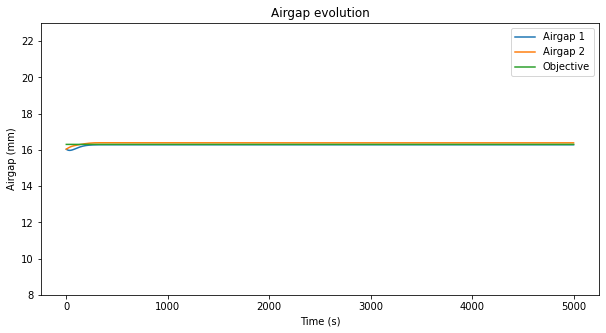

[-1.89738405 -1.89738405 -1.90985593 -1.90985593  0.          0.        ]
Time predict 11.010957717895508
Time model 54.14965748786926
Episode reward 5085.164422399543
[(0.0, 0.0), (-3.164069, -3.1658902), (-6.1752563, -6.18311), (-8.426977, -8.901212), (-8.409853, -11.240901), (-6.8534856, -11.376057), (-6.816255, -9.379722), (-8.237692, -9.150305), (-8.644356, -10.966119), (-7.740562, -11.248786), (-7.48564, -9.576781), (-8.3485775, -9.299551), (-8.781268, -10.900178), (-8.262398, -11.140034), (-7.994795, -9.57426), (-8.511251, -9.355651), (-8.882379, -10.896096), (-8.616857, -11.051805), (-8.402154, -9.497198), (-8.67981, -9.3676815), (-8.951798, -10.918067), (-8.858745, -10.972167), (-8.729168, -9.378213), (-8.8344555, -9.329757), (-8.987405, -10.921468), (-9.017642, -10.908052), (-8.990299, -9.261041), (-8.972192, -9.256321), (-8.997995, -10.892039), (-9.107779, -10.847221), (-9.188301, -9.152495), (-9.092057, -9.161376), (-8.995323, -10.832884), (-9.148167, -10.781221), (-9.33134

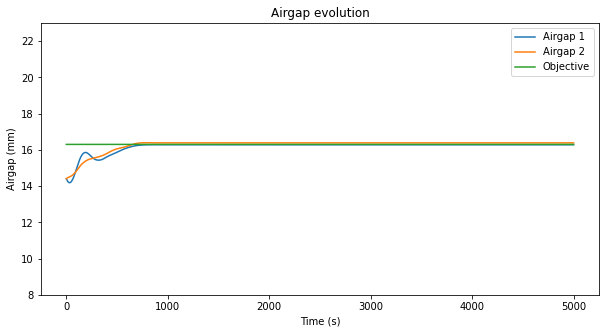

[3.9644522  3.9644522  4.00853292 4.00853292 0.         0.        ]
Time predict 10.983367204666138
Time model 53.55430603027344
Episode reward 5009.15289678796
[(0.0, 0.0), (2.9890947, 2.9890947), (5.9614367, 5.9614367), (8.922431, 8.922433), (11.899023, 11.899073), (14.875142, 14.876423), (17.80063, 17.834454), (20.025728, 20.794306), (19.56478, 23.801697), (18.651884, 26.780455), (20.396507, 29.609205), (23.244396, 32.277466), (24.954046, 34.793884), (22.367104, 37.16083), (20.285934, 39.38478), (22.535046, 41.448174), (23.02417, 42.590027), (19.622972, 40.719326), (18.684986, 38.88265), (21.641277, 39.92443), (22.781881, 40.13845), (19.786663, 37.48644), (18.567184, 36.137043), (21.485367, 37.770187), (21.605999, 37.66679), (18.321634, 34.78078), (17.834408, 33.8512), (20.737175, 35.739296), (21.884657, 35.171986), (18.985428, 31.67284), (17.826899, 30.812027), (20.71557, 32.815723), (21.191368, 32.74322), (18.072184, 29.900745), (17.389074, 27.155521), (20.287355, 26.705978), (23.

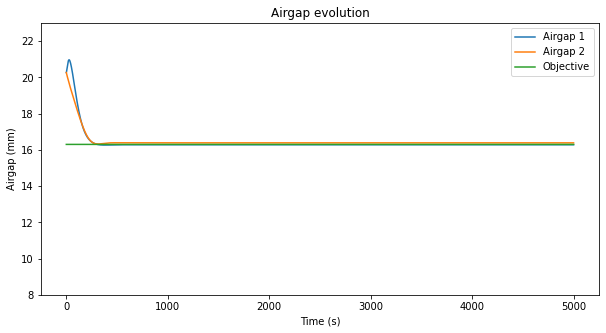

[-4.43030327 -4.43030327 -4.38430115 -4.38430115  0.          0.        ]
Time predict 11.215473890304565
Time model 53.685107946395874
Episode reward 5020.545055656188
[(0.0, 0.0), (-3.245934, -3.245909), (-6.3479867, -6.3479395), (-9.157046, -9.156985), (-11.674131, -11.674063), (-13.955988, -13.955913), (-16.07963, -16.079546), (-18.076551, -18.076384), (-19.960567, -19.96004), (-21.745989, -21.738415), (-23.443457, -23.420532), (-25.066841, -25.016214), (-26.625395, -26.43769), (-28.120987, -27.21652), (-29.54848, -27.067686), (-30.862148, -26.95583), (-31.906393, -27.563112), (-32.55675, -28.300978), (-32.838356, -28.774618), (-32.758232, -29.08875), (-32.394135, -29.338017), (-31.952961, -29.499243), (-31.559998, -29.562193), (-31.21045, -29.566854), (-30.854847, -29.563038), (-30.471577, -29.569801), (-30.072063, -29.578058), (-29.672728, -29.574759), (-29.277224, -29.556644), (-28.879675, -29.52769), (-28.475117, -29.491507), (-28.05947, -29.448227), (-27.636868, -29.395828), (

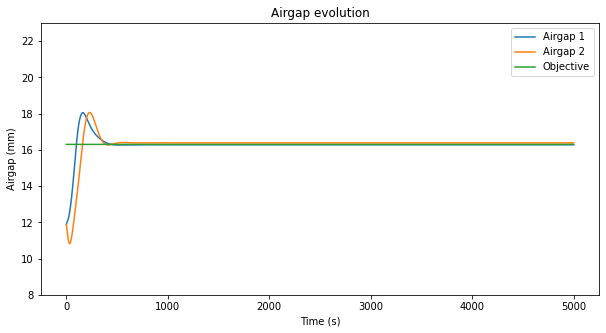

[3.90974443 3.90974443 3.91607754 3.91607754 0.         0.        ]
Time predict 10.74683952331543
Time model 53.620564460754395
Episode reward 5011.988847864538
[(0.0, 0.0), (2.9890947, 2.9890947), (5.9614367, 5.9614367), (8.922433, 8.922433), (11.899073, 11.899073), (14.876423, 14.876423), (17.834454, 17.834454), (20.79427, 20.794306), (23.800627, 23.801697), (26.759895, 26.780455), (29.530437, 29.609146), (31.187653, 32.208336), (28.494453, 32.87796), (26.60484, 31.126104), (29.108768, 30.636513), (30.480005, 31.864227), (27.534023, 30.813953), (25.883001, 29.258818), (28.561735, 30.38984), (29.881958, 31.031382), (26.900057, 28.556866), (25.2301, 27.649782), (27.83885, 30.064672), (29.408278, 29.752768), (26.675829, 26.126724), (23.536049, 25.513876), (24.70458, 28.303328), (27.46166, 30.068628), (27.902027, 27.61919), (24.5881, 24.667871), (22.778906, 25.952473), (24.75459, 28.72548), (27.512302, 27.455566), (26.207907, 22.927135), (21.054144, 22.490625), (20.02587, 25.454716), (2

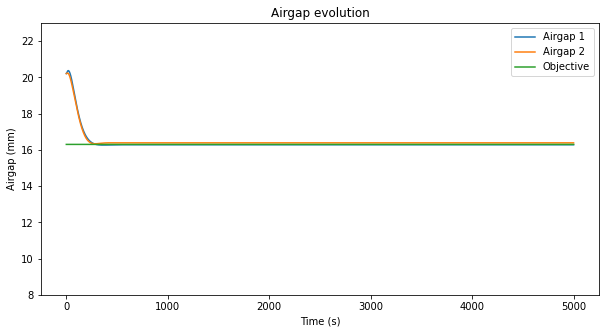

[0.85986743 0.85986743 0.86080048 0.86080048 0.         0.        ]
Time predict 10.77910566329956
Time model 53.37351131439209
Episode reward 5023.874486470954
[(0.0, 0.0), (2.9772835, 3.0267093), (5.259101, 6.0502534), (5.025939, 7.216587), (3.4143388, 5.35134), (3.616597, 4.1890206), (4.7807755, 5.768246), (4.5206428, 6.542098), (3.7018929, 4.764934), (3.8904622, 4.0189905), (4.232097, 5.7195473), (4.1376624, 6.0322747), (4.1692567, 4.035273), (3.8591468, 3.7469833), (3.3133368, 5.7227674), (3.9926822, 5.677166), (4.914089, 3.3788838), (3.738061, 3.2918463), (2.249046, 5.5227036), (3.35018, 5.4700203), (5.311756, 3.0437412), (4.42585, 2.902164), (1.8045673, 5.1592374), (2.106496, 5.1993556), (4.791938, 2.846777), (4.7194633, 2.6519463), (1.9676546, 4.8160834), (1.8790487, 4.8535767), (4.4881372, 2.5759351), (4.5296364, 2.4190245), (1.8892218, 4.5329566), (1.7828355, 4.5260983), (4.3303094, 2.2862582), (4.3301954, 2.164331), (1.7076629, 4.2691445), (1.6337868, 4.2713747), (4.171553, 

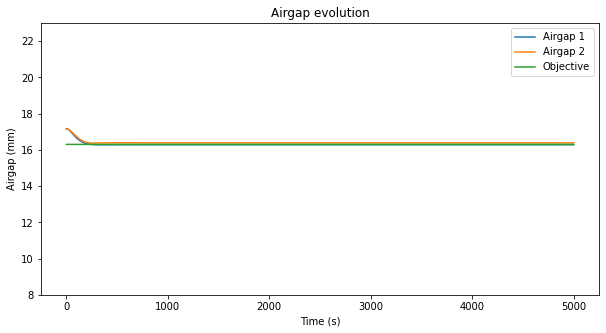

[-0.91302696 -0.91302696 -0.88307944 -0.88307944  0.          0.        ]
Time predict 10.986451148986816
Time model 53.4820442199707
Episode reward 5074.230169965651
[(0.0, 0.0), (-3.1065652, -3.1115866), (-6.063289, -5.8929276), (-8.747589, -6.0139666), (-11.176936, -3.80737), (-12.355932, -3.833257), (-11.275426, -6.109778), (-9.5796385, -6.2307134), (-9.568235, -4.0700583), (-10.46379, -3.9745326), (-10.067737, -6.1227036), (-8.751318, -6.2416387), (-8.471633, -4.1491156), (-9.0681305, -4.0651484), (-8.846352, -6.160703), (-7.85823, -6.2306223), (-7.557811, -4.1399846), (-7.9355397, -4.084223), (-7.7574925, -6.175654), (-7.0289216, -6.20936), (-6.790357, -4.100667), (-7.0132113, -4.0606685), (-6.8273025, -6.1594486), (-6.307516, -6.173832), (-6.171577, -4.049065), (-6.278655, -4.0163755), (-6.044819, -6.122252), (-5.689261, -6.125584), (-5.674201, -3.9892874), (-5.69405, -3.961537), (-5.396792, -6.0738387), (-5.1811686, -6.069884), (-5.3083715, -3.9252503), (-5.2826858, -3.9027462)

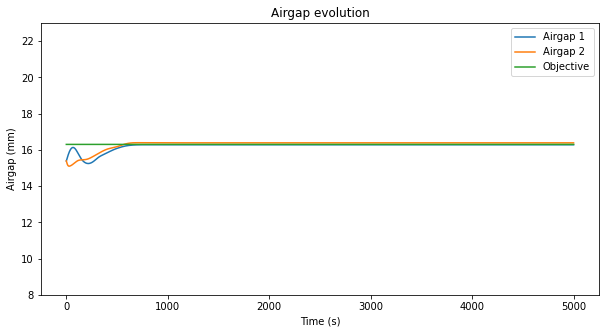

[-4.9265432  -4.9265432  -4.92680909 -4.92680909  0.          0.        ]
Time predict 10.810559034347534
Time model 53.718002796173096
Episode reward 4999.142595561948
[(0.0, 0.0), (-3.267957, -3.267923), (-6.4028206, -6.40276), (-9.252628, -9.252553), (-11.810808, -11.810724), (-14.111861, -14.111772), (-16.228483, -16.228388), (-18.216791, -18.216684), (-20.089262, -20.08915), (-21.85826, -21.85814), (-23.536928, -23.536806), (-25.137335, -25.137186), (-26.670864, -26.670322), (-28.147013, -28.142385), (-29.56962, -29.528257), (-30.942484, -30.63254), (-32.26957, -30.918203), (-33.55253, -30.570036), (-34.79119, -30.6541), (-35.984753, -31.287458), (-37.130424, -31.719852), (-38.218914, -31.666098), (-39.22511, -31.609938), (-40.098022, -31.916958), (-40.80558, -32.29501), (-41.3822, -32.461887), (-41.80071, -32.52827), (-42.000694, -32.65089), (-42.025684, -32.793915), (-41.964134, -32.88891), (-41.88128, -32.9068), (-41.796276, -32.861042), (-41.70274, -32.78108), (-41.592823, -32

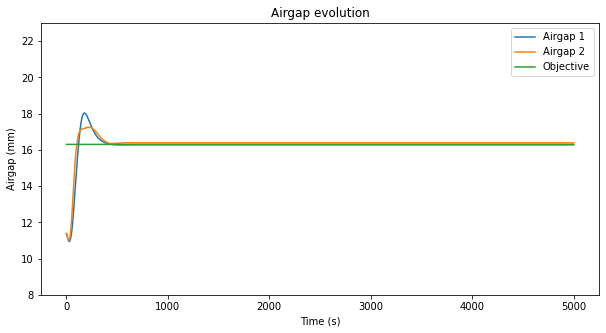

[-4.98248301 -4.98248301 -5.03429441 -5.03429441  0.          0.        ]
Time predict 10.813217401504517
Time model 53.22837781906128
Episode reward 4999.875502779554
[(0.0, 0.0), (-3.267957, -3.2679226), (-6.4028206, -6.4027615), (-9.252628, -9.252556), (-11.810808, -11.810728), (-14.11186, -14.111779), (-16.228477, -16.228401), (-18.215143, -18.21671), (-20.085482, -20.089184), (-21.853725, -21.858181), (-23.531809, -23.536846), (-25.131598, -25.147224), (-26.664618, -26.702456), (-28.140676, -28.201603), (-29.563599, -29.6411), (-30.936892, -30.95481), (-32.25016, -31.703287), (-33.506226, -31.395168), (-34.721703, -30.94344), (-35.89828, -31.32268), (-37.03755, -31.936872), (-38.140835, -31.954271), (-39.209198, -31.596127), (-40.24381, -31.665781), (-41.245327, -32.10224), (-42.21229, -32.249203), (-43.137177, -32.01057), (-43.994644, -31.93041), (-44.729435, -32.223442), (-45.0, -32.54826), (-45.0, -32.575665), (-45.0, -32.32434), (-45.0, -32.112217), (-45.0, -32.08906), (-45.0,

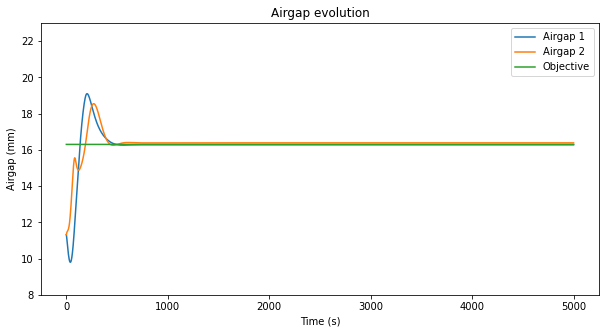

[-1.97616941 -1.97616941 -1.94467036 -1.94467036  0.          0.        ]
Time predict 11.335583209991455
Time model 53.601999282836914
Episode reward 5084.297805356572
[(0.0, 0.0), (-3.1651044, -3.1657503), (-6.1817937, -6.182807), (-8.900739, -8.895502), (-11.374859, -10.916309), (-13.669951, -10.530461), (-15.56055, -8.679672), (-15.673188, -8.96917), (-14.093393, -10.898043), (-13.406465, -10.867344), (-14.181152, -8.998927), (-14.518289, -8.994989), (-13.634753, -10.848028), (-12.921434, -10.956384), (-13.2435055, -9.198939), (-13.523102, -9.112725), (-12.927192, -10.858586), (-12.298369, -10.967743), (-12.415501, -9.271532), (-12.568156, -9.186219), (-12.059628, -10.877526), (-11.506665, -10.949411), (-11.528622, -9.264504), (-11.567441, -9.198893), (-11.086474, -10.873237), (-10.611946, -10.9059105), (-10.618882, -9.2065935), (-10.603735, -9.157196), (-10.158037, -10.833164), (-9.778615, -10.838883), (-9.811357, -9.119424), (-9.74955, -9.0785), (-9.305809, -10.761485), (-9.00699

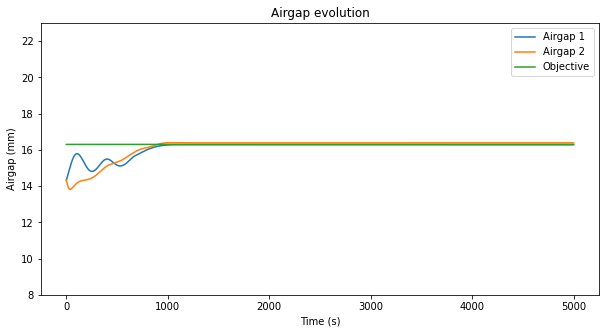

In [11]:
import numpy as np
import torch as th
import time

MODEL_PATH = f"models/2gdl8x8fs-passalis13a19/model.zip"

# Create and wrap the environment
env = TestAngleEnv(duration = 5)

# Load the trained agent
model = SAC.load(MODEL_PATH, env=env, learning_rate = 0.00001)

# Evaluate the agent
for i in range(10):
    obs, seed = env.reset()
    print(obs)
    done = False
    episode_reward = 0
    velocidad = 0
    current = 0
    observations = []
    noises = []
    timepredict = 0
    timemodel = 0
    distancia11, distancia12, distancia21, distancia22, current1, current2 = obs
    while not done:
        #noise = random.uniform(-1, 1)
        #obs = obs + noise
        observations.append(obs)
        #noises.append(noise)
        t1 = time.time()
        action, _states = model.predict(np.array([distancia11, distancia12, distancia21, distancia22, current1, current2]), deterministic=True)
        t2 = time.time()
        #print(action)
        #if env.airgap > 10.1: action = max(action, [-50])
        #print(action)
        t3 = time.time()
        state, reward, terminated, truncated, info = env.step(np.array(action))
        t4 = time.time()
        distancia11, distancia12, distancia21, distancia22, current1, current2 = state
        done = truncated or terminated
        episode_reward += reward
        timepredict += t2 - t1
        timemodel += t4 - t3
        noises.append((current1, current2))
    print("Time predict", timepredict)
    print("Time model", timemodel)
    print("Episode reward", episode_reward)
    print(noises)
    env.render("yes", normalize = True, seed = f"speedpassalis{i}")

In [167]:
import torch as th

from stable_baselines3 import SAC

#import onnx
import onnxruntime as ort
import numpy as np


class OnnxablePolicy(th.nn.Module):
    def __init__(self, actor: th.nn.Module):
        super().__init__()
        # Removing the flatten layer because it can't be onnxed
        self.actor = th.nn.Sequential(
            actor.latent_pi,
            actor.mu,
            # For gSDE
            # th.nn.Hardtanh(min_val=-actor.clip_mean, max_val=actor.clip_mean),
            # Squash the output
            th.nn.Tanh(),
        )

    def forward(self, observation: th.Tensor) -> th.Tensor:
        # NOTE: You may have to process (normalize) observation in the correct
        #       way before using this. See `common.preprocessing.preprocess_obs`
        return self.actor(observation)


# Example: model = SAC("MlpPolicy", "Pendulum-v1")
model = SAC.load(f"models/sac8x8h9.3/model.zip", device="cpu")
onnxable_model = OnnxablePolicy(model.policy.actor)

observation_size = model.observation_space.shape
dummy_input = th.randn(1, *observation_size)
th.onnx.export(
    onnxable_model,
    dummy_input,
    "./ONNX/1gdlComplexH98x8.onnx",
    opset_version=9,
    input_names=["input"],
)

##### Load and test with onnx

import onnxruntime as ort
import numpy as np

onnx_path = "./ONNX/1gdlComplexH98x8.onnx"

observation = np.zeros((1, *observation_size)).astype(np.float32)
ort_sess = ort.InferenceSession(onnx_path)
action = ort_sess.run(None, {"input": observation})

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



: 

In [12]:
model.policy

SACPolicy(
  (actor): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=8, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=8, out_features=1, bias=True)
    (log_std): Linear(in_features=8, out_features=1, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (qf0): Sequential(
      (0): Linear(in_features=5, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
    (qf1): Sequential(
      (0): Linear(in_features=5, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
   

In [ ]:
# See "ONNX export" for imports and OnnxablePolicy
jit_path = "1gdlComplex.pt"

# Trace and optimize the module
traced_module = th.jit.trace(onnxable_model.eval(), dummy_input)
frozen_module = th.jit.freeze(traced_module)
frozen_module = th.jit.optimize_for_inference(frozen_module)
th.jit.save(frozen_module, jit_path)

##### Load and test with torch

import torch as th

dummy_input = th.randn(1, *observation_size)
loaded_module = th.jit.load(jit_path)
action_jit = loaded_module(dummy_input)